In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, array_to_img

from keras import Model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
vgg = VGG16()

In [4]:
def predict_image_using_vgg(img_path, vgg):
    """
    Open image, convert it to an array, and run predictions
    using a trained model.
    """
    # load an image from file
    image = load_img(img_path, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape(
        (1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    y_pred = vgg.predict(image)
    print(y_pred.shape)
    labels = decode_predictions(y_pred)[0]
    for label in labels:
        print(label)
        

In [5]:
predict_image_using_vgg('../img/mug.jpg', vgg)

(1, 1000)
('n03063599', 'coffee_mug', 0.75266147)
('n03063689', 'coffeepot', 0.08365984)
('n07930864', 'cup', 0.06440081)
('n04398044', 'teapot', 0.030264238)
('n03950228', 'pitcher', 0.025889609)


### Creating a dataset

In [6]:
import os
import glob
import numpy as np

def create_dataset(folder):
    all_images = []
    image_arrays = []
    all_labels = []
    filenames = []
    for class_id, label in enumerate(os.listdir(folder)):
        if ".DS_Store"!=label :
            print(class_id, label)
        
            for filename in glob.glob(folder + '/{}/*'.format(label)):
                filenames.append(filename)
                im = load_img(filename, target_size=(224, 224))
                all_images.append(im)
                preprocessed = preprocess_input(img_to_array(im))
                image_arrays.append(preprocessed)
                all_labels.append(class_id)
        
    X = np.array(image_arrays)
    Y = to_categorical(np.array(all_labels))
    return X, Y, filenames, all_images

In [7]:
X, Y, filenames, all_images = create_dataset('../img/vetements')

0 tshirt


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/PIL/Image.py:966: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


1 bonnet
3 chaussure
4 sweatshirt
5 chausette
6 pantalon
7 boxer


In [8]:
X.shape

(1053, 224, 224, 3)

In [9]:
X[0][:2,:2]


array([[[131.061, 118.221, 111.32 ],
        [131.061, 118.221, 111.32 ]],

       [[130.061, 117.221, 110.32 ],
        [130.061, 117.221, 110.32 ]]], dtype=float32)

len(all_images), len(all_labels), len(image_arrays)

In [10]:
X.shape, Y.shape, len(filenames), len(all_images)

((1053, 224, 224, 3), (1053, 8), 1053, 1053)

In [11]:
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [12]:
filenames[:3]

['../img/vetements/tshirt/T-Shirt-Porteur-Saint-zoom-500x630.png',
 '../img/vetements/tshirt/t-shirt-canard.jpg',
 '../img/vetements/tshirt/size-discout-hot-new-tshirt-couleur-jersey.jpg']

(1, 1000)
('n03595614', 'jersey', 0.9713966)
('n04370456', 'sweatshirt', 0.026713574)
('n03710637', 'maillot', 0.00030555722)
('n03291819', 'envelope', 0.00017204355)
('n02730930', 'apron', 0.00016864049)


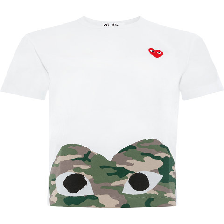

In [13]:
img_id = 11
predict_image_using_vgg(filenames[img_id], vgg)
all_images[img_id]

####  TODO Commentaire sur le résultat de VGG16 (est-ce que les classes ont du sens pour notre example ou pas)

### Transfer learning

In [14]:
# Charger VGG-16 pré-entraîné sur ImageNet
# mais sans les couches fully-connected
vgg_cut = VGG16(weights="imagenet", include_top=False,
                input_shape=(224, 224, 3))
x = vgg_cut.output
# transform matrix into 1-d vector
x = Flatten()(x)

# TODO essayer de modifier le nombre de neurones  
x = Dense(30, activation='relu')(x) 

# TODO parametrer le nombre de classes (9 ici)
nb_classes = 8
x = Dense(nb_classes, activation='softmax')(x)  



In [15]:
custom_model = Model(inputs=vgg_cut.input, outputs=x)

In [16]:
# stratégie de Transfer Learning: extraction de features
# On entraîne seulement le nouveau classificateur,
# et on NE ré-entraîne PAS les autres couches.
# On utilise les autres couches uniquement pour 
# extraire des features des images
for layer in custom_model.layers[:-2]:
    layer.trainable = False

In [17]:
custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [18]:
# Compiler le modèle 
custom_model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(lr=0.0001, momentum=0.9),
    metrics=["accuracy"])

In [58]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=10, batch_size=5)
# TODO essayer de changer epochs=3 (5, 10)

Epoch 1/10
1053/1053 [==============================] - 257s 244ms/step - loss: 8.4188 - acc: 0.4777
Epoch 2/10
1053/1053 [==============================] - 264s 251ms/step - loss: 8.4188 - acc: 0.4777
Epoch 3/10
1053/1053 [==============================] - 263s 250ms/step - loss: 8.4188 - acc: 0.4777
Epoch 4/10
1053/1053 [==============================] - 263s 249ms/step - loss: 8.4188 - acc: 0.4777
Epoch 5/10
1053/1053 [==============================] - 263s 250ms/step - loss: 8.4188 - acc: 0.4777
Epoch 6/10
1053/1053 [==============================] - 267s 254ms/step - loss: 8.4188 - acc: 0.4777
Epoch 7/10
1053/1053 [==============================] - 269s 256ms/step - loss: 8.4188 - acc: 0.4777
Epoch 8/10
1053/1053 [==============================] - 263s 250ms/step - loss: 8.4188 - acc: 0.4777
Epoch 9/10
1053/1053 [==============================] - 262s 249ms/step - loss: 8.4188 - acc: 0.4777
Epoch 10/10
1053/1053 [==============================] - 263s 250ms/step - loss: 8.4188 - a

#### Utilisons notre modèle entrainé pour faire des prédictions sur les images de test

In [59]:
# télécharger les images de test (sans libellé, tout dossier TEST)
def load_test_set(folder):
    all_images = []
    image_arrays = []
    filenames = []
    for filename in glob.glob(folder + '/*'):
        filenames.append(filename)
        im = load_img(filename, target_size=(224, 224))
        all_images.append(im)
        preprocessed = preprocess_input(img_to_array(im))
        image_arrays.append(preprocessed)
    X = np.array(image_arrays)
    return X, filenames, all_images

In [60]:
X_test, test_filenames, test_images = load_test_set(
    '../img/vetements_test/')

In [61]:
def get_labels(folder):
    labels = []
    class_ids = []
    for class_id, label in enumerate(os.listdir(folder)):
        # on créer les labels et leurs id correspondant sans prendre en compte le dossier DS_store
        if ".DS_Store"!=label :
            labels.append(label)
            if(class_id>2) :
                class_id = class_id - 1
            class_ids.append(class_id)
            print(class_id, label)
    return labels, class_ids

In [62]:
test_labels, test_classid = get_labels('../img/vetements')

0 tshirt
1 bonnet
2 chaussure
3 sweatshirt
4 chausette
5 pantalon
6 boxer


In [63]:
def interpret_results(labels, predictions):
    i = 0
    for label in labels:
        print(label, predictions[0][i])
        # on realise ici un test et une incrementation de i afin de passer outre le dossier .DS_store
        # if(i==1):
            # i=i+1
        i = i+1

In [64]:
X_test.shape

(64, 224, 224, 3)

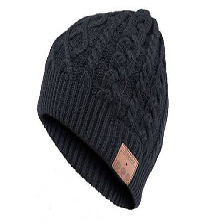

In [65]:
test_id = 4
test_images[test_id]

In [66]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

array([[0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 7.4505270e-24, 1.6990503e-26, 1.1356425e-35]],
      dtype=float32)

In [67]:
def predict_image_using_custom(img_path, custom_model):
    """
    Open image, convert it to an array, and run predictions
    using a trained model.
    """
    # load an image from file
    image = load_img(img_path, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape(
        (1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    y_pred = custom_model.predict(image)
    
    return y_pred

In [77]:
test_id = 16
my_pred = predict_image_using_custom(test_filenames[test_id], custom_model)


####  TODO Commentaire sur le résultat des prédiction de notre modèle custom

In [78]:
interpret_results(test_labels, my_pred)

tshirt 0.0
bonnet 9.708014e-25
chaussure 0.0
sweatshirt 2.6008268e-38
chausette 1.7625691e-30
pantalon 3.0514685e-16
boxer 1.0


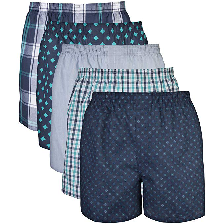

In [79]:
test_images[test_id]

# Projet
1. Trouver le sujet de classification d'images
2. Créer le jeu de données:
    * Télécharger les images de l'Internet
    * Utiliser le plugin ""Download All Images"" de navigateur pour aller plus vite:
    * Saisir la requete sur Google Images (par exemple)
    * Cliquer sur "Download All Images" (le plugin du navigateur)
    * Dézipper le fichier téléchargé
    * Récupérer seulement des images pertinentes
    * Mettre ces images dans votre arboscence:
        "img/<nom_de_l_equipe>/<un_dossier_par_catégorie>/*.png"
    * Créer des matrices X et Y à partir des images:
        * itérateur sur les dossiers et les images;
        * chargement des images;
        * preprocessing lié à VGG16 (ou autre modèle CNN préentrainé que vous allez utiliser);
        * création du numpy.array finale depuis la liste des images chargés et prétraités;
        * création du vecteur de "labels" à partir des noms de dossiers parcourus, pour chaque image ("adidas adidas adidas cocacola cocacola fdj fdj fdj fdj ....");
        * conversion du vecteur 1-dimensionnel de labels en vecteur M-dimensionnel, où M = nombre de catégories de votre problème: pour cela, utiliser la fonction *to_categorical*. Chaque label doit donc être un vecteur avec des 0.0 et une seule valeur 1.0 sur la position qui correspond à la bonne catégorie.
        
3. Utiliser un des modèles CNN (convolutional neural network) déjà entrainé (comme VGG ou autre, cf. ici https://keras.io/applications/) pour faire des prédictions sur quelques images de votre dataset. Utiliser "decode_predictions" pour afficher à quelles classes appartient des valeurs maximales du vecteur de prédiction

* Comme votre use case est spécifique, et les classes présentes dans le modèle VGG ne correspondent pas à votre problème. Il faut donc faire du Transfer Learning:
    * Prendre un modèle pré-entrainé (VGG par exemple), mais ne pas utiliser sa dernière couche! (include_top=False). Ne pas oublier de spécifier le format des images en entrée ((224, 224, 3) pour VGG). 
    * Ajouter une couche Flatten() pour aplaitir la matrice pour obtenir le vecteur 1-dimensionnel.
    * Ajouter une couche Dense(nb_classes, activation="softmax")
    * Créer un modele *custom* qui va utiliser ces couches-là.
    * Comme le modèle VGG sera en version "cut" ("truncated"), donc elle ne sera pas utilisé pour les prédictions mais seulement pour extraction de features. Donc, il faut préciser que les couches du modèle custom soit déclarés comme "layer.trainable = False". Utiliser l'itérateur sur "custom_model.layers" afin de préciser quelles couches ne pas entrainer.
    * Vérifier avec "custom_model.summary()" que seulement les paramètres qui correspondent à la dernière couche Dense seront entrainés (cf. les messages "Total parameters, Trainable parameters, Non-Trainable parameters" du summary.
    * Déclarer la méthod de "compilation" du modèle (fonction de perte, algorithme, métrique) avec "custom_model.compile(....)"
    * Finalement, ENTRAINER le modèle avec la commande "custom_modèle.fit". Utiliser plusieurs nombre de *epochs* (plus est mieux, quitte à laisser le modèle s'entrainer pendant plusieurs heures); varier le *batch_size* en fonction de nombre totale d'images dans votre dataset (batch_size plus élevé accélère l'entrainement mais dégrade le résultat; par contre valeur 1 risque de finir par le "overfit", "surapprentissage", où le modèle va apprendre par coeur des exemple, mais mal généraliser sur des nouvelles images, donc le score sera mauvais aussi. Trouver la bonne valeur de batch_size, commenter les étapes de votre expérimentation.
    
    
* Charger des images depuis le dossier "img/test_images", utiliser le même prétraitement afin d'avoir le même format que des matrices X (pas besoin de Y ici, car vous allez juste lancer des prédictions).
* Lancer des prédictions sur ces nouvelles images (custom_model.predict).
* Interpréter des prédictions. Quelle catégorie donne la proba maximale?  Afficher l'image dans notebook pour voir ce qu'elle représente. Est-ce que c'est la bonne catégorie qui a été prédite?


#### Faire un résumé du projet: qu'est-ce que vous avez fait, quels résultats obtenus. Quel score a votre modèle, est-ce qu'elle prédit bien sur des images de test.
#### Commentez votre code!!! 
    
### livrables: GITHUB!!! code + images + requirements.txt, la même arborescence que dl MAIS SANS DOSSIER MYENV!!!  requirements.txt suffira pour recréer "myenv" lors de la correction

### denis.lazarenko@gmail.com


### deadline: 28 avril 2019 , 23:59:59
### questions par mail


#### Liens utils
* training Keras models: 
  https://keras.io/getting-started/sequential-model-guide/
* deep learning tutorial: https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
* convolution filter produces a feature map (animation): https://www.youtube.com/watch?v=KiftWz544_8

J'ai réalisé une étude sur l'apprentissage de la reconnaissance de vêtements via l'utilisation d'un algorithme de tranfert learning.
L'algorithme s'est entrainer sur 7 classes différentes : tshirt, pantalon, bonnet, sweatshirt, chaussure, chaussette et boxer

Sur l'algorithme vgg16 nous propose ici des resultat relativement cohérents avec le theme de nos images. En effet on observe que l'algorithme nous propose en premiere position avec une tres grande certitude (+95%) une matière dans laquelle le t-shirt a pu être faites meme si la qualite de l'image ne me permet pas de l'affirmer.
De plus la plupart des autres propositions reste dans le domaine du vestimentaire, ne particulier des hauts, ce qui est pertinent avec l'exemple etant un t-shirt. 
Cependant il semblerais qu'après des test avec plusieurs images différentes, la categorie t-shirt ne soit juste pas présente, ce qui justifirais que l'algorithme ne reconnais pas la catégorie reelle de l'objet en question.
On peut en conclure que l'algorithme vgg n'as pas été entrainé sur un set de données correspondant aux catégories sur lesquelles je souhaitais réaliser mon étude.


J'ai pu réaliser trois fonctions, une qui reprenait le modele de predict_image_using_vgg en utilisant notre algorithme custom. Une qui récupère les labels sur lesquels j'ai pu entrainer l'algorithme et une  qui interprete les resultats, associant label au taux de reconnaissance de l'algorithme.

Durant les expérimentation, j'ai essayer plusieurs combinaison entre le nombre d'epoch et la taille du batch ((3,5),(5,5),(10,5),(3,10),(5,10),(10,15)) et j'ai trouvé que augmenter la taille du batch au dela de 5 donnais des resultats vraiment peu precis et peu concluant sur l'ensemble de test.
J'ai donc gardé les valeurs 10 pour epoch et 5 pour batch afin d'avoir un bon rapport entre le temps d'entrainement et la précision des résultats sur les tests.
Cependant on remarque quand même que certaines prédictions sont fausses et ce qui a pu induire ces erreurs est du a la qualité des images (en géneral ces erreurs sont produites sur des images très pixelisées) ou  encore une ressemblance au niveau de la disposition (entre autre, une image ayant plusieurs boxers dessus a été confondu avec des chaussettes, sachant que plusieurs images de chaussettes sont composé de la même manière)
Pour améliorer les prédictions, j'aurai pu être plus méticuleux sur le choix des images d'entrainement (par exemple pour le cas des chaussettes-boxers) ou entrainer plus longuement l'algorithme en augmentant le nombre d'epoch et eventuellement en baissant le taille du batch.

Dans ma fonction permettant l'interpretation des resultats, je me suis rendu compte que le fichier .DS_store, fichier caché présent sur mac, posait certains problèmes car il créé un groupe de classification en plus. J'ai du gérer ce cas particulier à la main et donc si des résultats semblent incohérents sur un autre OS, il se peut que cela vienne des lignes commentées de la fonction interpret_results.

note par rapport au projet : a cause de soucis de connexion et de restriction sur l'upload de fichier avec Github, j'ai du mettre les photos de l'entrainement et des tests dans des fichier zip ne dépassant pas 25Mb.
Il faut donc dezipper les fichiers dans les dossiers ou ils sont placés.